<a href="https://colab.research.google.com/github/nischitabiradar/BDA-696-Project---Fashion-Product-Classification-and-Recommendation/blob/main/URL_recommendation_with_UI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install flask flask_ngrok

In [ ]:
from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp '/content/drive/MyDrive//kaggle.json' ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download paramaggarwal/fashion-product-images-small

100% 563M/565M [00:05<00:00, 114MB/s] 
100% 565M/565M [00:05<00:00, 99.1MB/s]


In [ ]:
! unzip fashion-product-images-small.zip

In [ ]:
!pip install -q swifter torchvision opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import pathlib
import os
# Importing matplotlib for plotting
import matplotlib.pyplot as plt
#set style
plt.style.use('ggplot')

# Importing numpy for numerical operations
import numpy as np

# Importing pandas for preprocessing
import pandas as pd

# Importing joblib to dump and load embeddings df
import joblib


# Importing cv2 to read images
import cv2

# Importing cosine_similarity to find similarity between images
from sklearn.metrics.pairwise import cosine_similarity

# Importing flatten from pandas to flatten 2-D array
from pandas.core.common import flatten

# Importing the below libraries for our model building

#import torch
import torch
import torch.nn as nn

#import cv models
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

#import image
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [ ]:
DATASET_PATH = '/content/myntradataset/'
print(os.listdir(DATASET_PATH))

['styles.csv', 'images']


In [ ]:
# Using error_bad_lines and warn_bad_lines parameters to avoid reading bad lines in this dataset
df = pd.read_csv(DATASET_PATH + 'styles.csv',error_bad_lines=False,warn_bad_lines=False, nrows = 5000)

#top 10 rows
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Skagen Men Black Watch


In [ ]:
%%time
import os

def get_all_filenames(directory):
    """
    Returns a set of all filenames in the given directory.
    """
    filenames = {entry.name for entry in os.scandir(directory) if entry.is_file()}
    return filenames

images = get_all_filenames(DATASET_PATH + "images/")


CPU times: user 19.3 ms, sys: 17.3 ms, total: 36.7 ms
Wall time: 42.7 ms


In [ ]:
def check_image_exists(image_filename):
    """
    Checks if the desired filename exists within the filenames found in the given directory.
    Returns True if the filename exists, False otherwise.
    """
    global images
    if image_filename in images:
        return image_filename
    else:
        return np.nan

df['image'] = df["id"].apply(lambda image: check_image_exists(str(image) + ".jpg"))
df = df.reset_index(drop=True)
df.head()


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


In [ ]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

#image path
def image_location(img):
    return DATASET_PATH + 'images/'  + img

# function to load image
def import_img(image):
    image = cv2.imread(image_location(image))
    return image


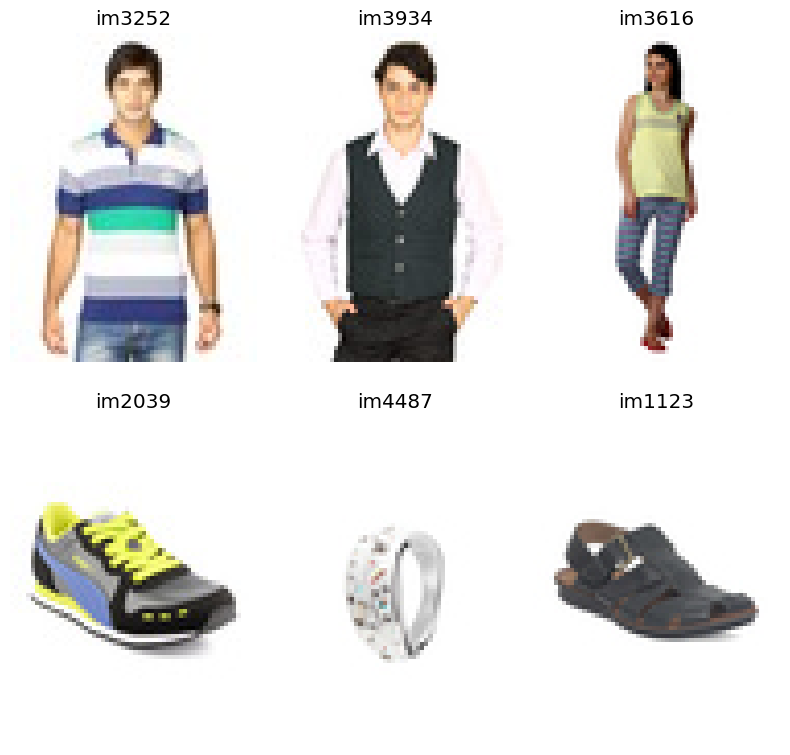

In [ ]:
# generation of a dictionary of (title, images)
figures = {'im'+str(i): import_img(row.image) for i, row in df.sample(6).iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures,2,3)

In [ ]:
width, height = 224, 224

# Loading the pretrained model
resnetmodel = models.resnet18(pretrained=True)

# Use the model object to select the desired layer
layer = resnetmodel._modules.get('avgpool')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


In [ ]:
#evaluate the model
resnetmodel.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# scaling the data
s_data = transforms.Resize((224, 224))

#normalizing
standardize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# converting to tensor
convert_tensor = transforms.ToTensor()

In [ ]:
#missing image object
missing_img = []
#function to get embeddings

def vector_extraction(resnetmodel, image_id):

    # Using concept of exception handling to ignore missing images
    try:
        # 1. Load the image with Pillow library
        img = Image.open(image_location(image_id)).convert('RGB')

        # 2. Create a PyTorch Variable with the transformed image
        t_img = Variable(standardize(convert_tensor(s_data(img))).unsqueeze(0))

        # 3. Create a vector of zeros that will hold our feature vector
        # The 'avgpool' layer has an output size of 512
        embeddings = torch.zeros(512)

        # 4. Define a function that will copy the output of a layer
        def copy_data(m, i, o):
            embeddings.copy_(o.data.reshape(o.data.size(1)))

        # 5. Attach that function to our selected layer
        hlayer = layer.register_forward_hook(copy_data)

        # 6. Run the model on our transformed image
        resnetmodel(t_img)

        # 7. Detach our copy function from the layer
        hlayer.remove()
        emb = embeddings

        # 8. Return the feature vector
        return embeddings

    # If file not found
    except FileNotFoundError:
        # Store the index of such entries in missing_img list and drop them later
        missed_img = df[df['image']==image_id].index
        print(missed_img)
        missing_img.append(missed_img)

In [ ]:
# Testing if our vector_extraction function works well on sample image
sample_embedding_0 = vector_extraction(resnetmodel, df.iloc[0].image)

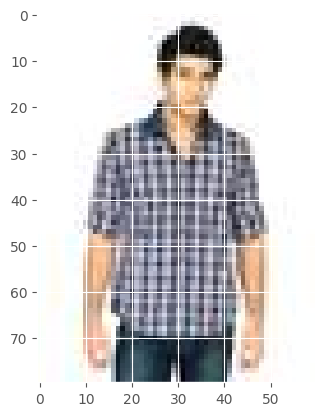

In [ ]:
# Plotting the sample image and its embeddings
img_array = import_img(df.iloc[0].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
# # print(img_array.shape)
# print(sample_embedding_0)

In [ ]:
df.shape

(5000, 11)

In [ ]:
%%time
import swifter

# Applying embeddings on subset of this huge dataset
df_embeddings = df #We can apply on entire df, like: df_embeddings = df

#looping through images to get embeddings
map_embeddings = df_embeddings['image'].swifter.apply(lambda img: vector_extraction(resnetmodel, img))

#convert to series
df_embs        = map_embeddings.apply(pd.Series)
print(df_embs.shape)
df_embs.head()

Pandas Apply:   0%|          | 0/5000 [00:00<?, ?it/s]

(5000, 512)
CPU times: user 6min 21s, sys: 1min 3s, total: 7min 24s
Wall time: 7min 47s


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.018092,1.042106,0.030759,0.106612,0.248215,1.314161,0.070166,0.269750,1.374099,0.434485,...,0.663422,0.474600,1.207340,0.723219,0.000000,0.037897,1.661622,0.838834,0.006767,0.024396
1,0.034120,0.804466,0.071094,0.286108,0.118644,0.485673,0.767112,0.116924,1.131223,1.229429,...,0.125503,0.554489,0.160279,0.211642,0.000000,0.921632,1.210377,0.750111,0.015514,0.182357
2,0.306779,0.196792,2.325821,0.337870,0.206403,0.410262,2.865741,0.493548,2.894565,3.824199,...,0.377006,3.216578,2.293663,1.343938,1.047548,0.016881,2.759720,0.630301,0.114623,0.002224
3,0.052566,0.312827,0.318464,0.045759,0.207993,0.486138,0.871358,0.437959,0.861974,1.257671,...,0.000402,0.126219,0.117900,0.174460,0.000000,0.004943,1.039022,0.150582,0.009435,0.015908
4,0.146032,0.624986,0.023858,0.201499,0.273301,2.073839,0.038832,0.537266,1.338016,0.428539,...,0.039452,1.069757,0.774632,0.874318,0.000000,0.010583,2.638507,0.303630,0.005840,0.026666


In [ ]:
# Specify the directory path
directory_path = '/content/working'

# Create the directory
os.makedirs(directory_path, exist_ok=True)

# List the contents of the current working directory to verify
print(os.listdir('/content'))

['.config', 'drive', 'myntradataset', 'styles.csv', 'images', 'fashion-product-images-small.zip', 'working', 'sample_data']


In [ ]:
#export the embeddings
df_embs.to_csv('/content/working/df_embs.csv')

# importing the embeddings
df_embs = pd.read_csv('/content/working/df_embs.csv')
df_embs.drop(['Unnamed: 0'],axis=1,inplace=True)
df_embs.dropna(inplace=True)


In [ ]:
#exporting as pkl
joblib.dump(df_embs, '/content/working/df_embs.pkl', 9)

#importing the pkl
df_embs = joblib.load('/content/working/df_embs.pkl')

In [ ]:
# Calculating similarity between images ( using embedding values )
cosine_sim = cosine_similarity(df_embs)

# Previewing first 4 rows and 4 columns similarity just to check the structure of cosine_sim
cosine_sim[:4, :4]

array([[1.        , 0.76400116, 0.54799321, 0.77531746],
       [0.76400116, 1.        , 0.49617084, 0.88492659],
       [0.54799321, 0.49617084, 1.        , 0.52310666],
       [0.77531746, 0.88492659, 0.52310666, 1.        ]])

In [ ]:
# Storing the index values in a series index_vales for recommending
index_vales = pd.Series(range(len(df)), index=df.index)
index_vales

# Defining a function that gives recommendations based on the cosine similarity score
def recomend_images(ImId, df, top_n = 6):

    # Assigning index of reference into sim_ImId
    sim_ImId    = index_vales[ImId]

    # Storing cosine similarity of all other items with item requested by user in sim_scores as a list
    sim_scores = list(enumerate(cosine_sim[sim_ImId]))

    # Sorting the list of sim_scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Extracting the top n values from sim_scores
    sim_scores = sim_scores[1:top_n+1]

    # ImId_rec will return the index of similar items
    ImId_rec    = [i[0] for i in sim_scores]

    # ImId_sim will return the value of similarity score
    ImId_sim    = [i[1] for i in sim_scores]

    return index_vales.iloc[ImId_rec].index, ImId_sim

# Sample given below
recomend_images(3810, df, top_n = 5)


(Int64Index([2400, 3678, 3899, 2354, 1247], dtype='int64'),
 [0.9609788054524162,
  0.9585812667493732,
  0.9572631195534331,
  0.9567468253281909,
  0.9551633556225657])

In [ ]:
def Rec_viz_image(input_imageid):

    # Getting recommendations
    idx_rec, idx_sim = recomend_images(input_imageid, df, top_n = 6)

    # Printing the similarity score
    print (idx_sim)

    # Plotting the image of item requested by user
    plt.imshow(cv2.cvtColor(import_img(df.iloc[input_imageid].image), cv2.COLOR_BGR2RGB))

    # Generating a dictionary of { index, image }
    figures = {'im'+str(i): import_img(row.image) for i, row in df.loc[idx_rec].iterrows()}

    # Plotting the similar images in a figure, with 2 rows and 3 columns
    plot_figures(figures, 2, 3)

[0.9609788054524162, 0.9585812667493732, 0.9572631195534331, 0.9567468253281909, 0.9551633556225657, 0.9547181298422864]


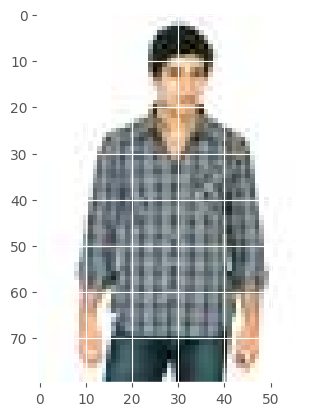

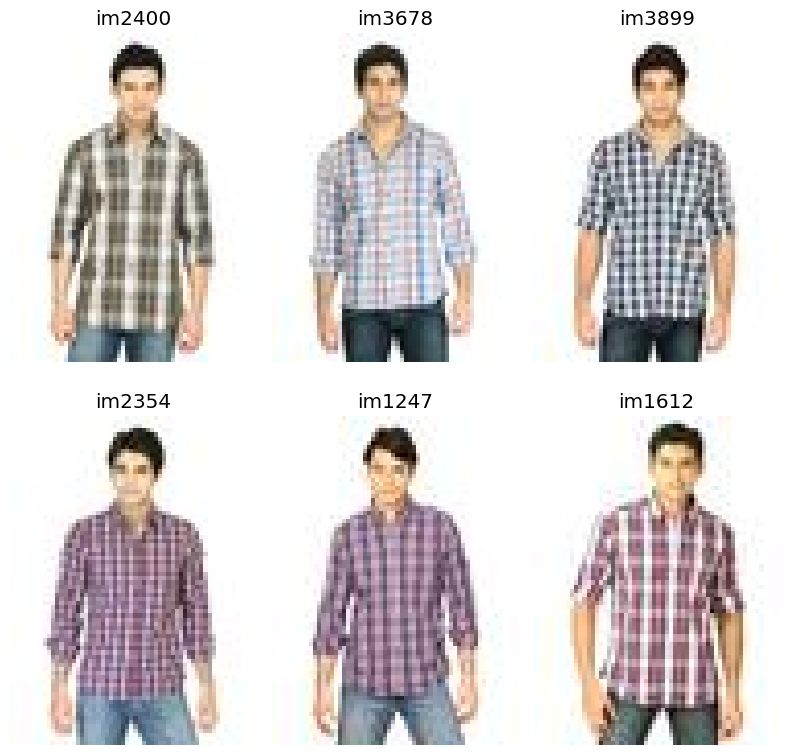

In [ ]:
Rec_viz_image(3810)

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2023-12-15 00:07:03--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.161.241.46, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  19.9MB/s    in 0.7s    

2023-12-15 00:07:04 (19.9 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
! /content/ngrok authtoken 2ZTic5usQOzcSIWeBwWH3eeh0dy_6GDzyLRgpaQJRn2ybpFsi

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

Enter the URL: https://m.media-amazon.com/images/W/MEDIAX_792452-T2/images/I/51e8XU5OkKL._AC_UY1000_.jpg
4024    0.809594
4329    0.808915
2041    0.808282
2358    0.803033
3761    0.801640
Name: Score, dtype: float64
4024    16155.jpg
Name: image, dtype: object
4329    30261.jpg
Name: image, dtype: object
2041    23679.jpg
Name: image, dtype: object
2358    17822.jpg
Name: image, dtype: object
3761    16152.jpg
Name: image, dtype: object


['16155.jpg', '30261.jpg', '23679.jpg', '17822.jpg', '16152.jpg']

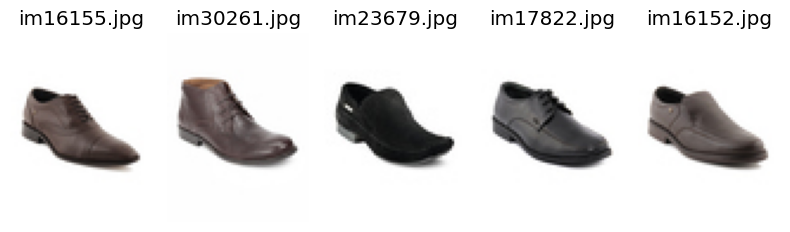

In [ ]:
import requests
import io
from PIL import Image

def recm_user_input(url):
    try:
        # Download the image from the URL
        response = requests.get(url)
        img = Image.open(io.BytesIO(response.content)).convert('RGB')

        # Rest of the code
        t_img = Variable(standardize(convert_tensor(s_data(img))).unsqueeze(0))
        embeddings = torch.zeros(512)

        def select_d(m, i, o):
            embeddings.copy_(o.data.reshape(o.data.size(1)))

        hlayer = layer.register_forward_hook(select_d)
        resnetmodel(t_img)
        hlayer.remove()
        emb = embeddings

        cs = cosine_similarity(emb.unsqueeze(0), df_embs)
        cs_list = list(flatten(cs))
        cs_df = pd.DataFrame(cs_list, columns=['Score'])
        cs_df = cs_df.sort_values(by=['Score'], ascending=False)

        print(cs_df['Score'][:5])

        top5 = cs_df[:5].index
        top5 = list(flatten(top5))
        images_list = []

        for i in top5:
            image_id = df[df.index == i]['image']
            print(image_id)
            images_list.append(image_id)

        images_list = list(flatten(images_list))

        figures = {'im' + str(i): Image.open('/content/myntradataset/images/' + i) for i in images_list}
        fig, axes = plt.subplots(1, 5, figsize=(8, 8))

        for index, name in enumerate(figures):
            axes.ravel()[index].imshow(figures[name])
            axes.ravel()[index].set_title(name)
            axes.ravel()[index].set_axis_off()

        plt.tight_layout()
        return(images_list)

    except Exception as e:
        print("Error:", str(e))

# Example usage with a URL
input_url = input("Enter the URL: ")
recm_user_input(input_url)

In [ ]:
!mkdir templates

In [ ]:
# Create 'index.html' template
with open('templates/index.html', 'w') as file:
    file.write('''
<!DOCTYPE html>
<html lang="en">
<head>
    <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/css/bootstrap.min.css">
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Fashion Recommendation</title>
</head>
<body class="bg-light">
    <div class="container mt-5">
        <h1 class="text-center">Welcome to the Fashion Recommender!</h1>
        <form action="/recommendation" method="post" class="mt-4">
        <label for="image_url">Enter Image URL:</label>
        <input type="text" id="image_url" name="image_url" required>
        <button type="submit">Get Recommendation</button>
    </form>
</body>
</html>
''')


In [ ]:
# Route for the main page
@app.route('/')
def index():
    return render_template('index.html')

In [ ]:
# Route for displaying recommendations
@app.route('/recommendation', methods=['POST'])
def show_recommendation():
    try:
        url = request.form['image_url']
        images_list = recm_user_input(url)
        return render_template('result.html', images_list=images_list)
    except Exception as e:
        error_message = "Error: " + str(e)
        return render_template('error.html', error_message=error_message)

In [ ]:
# Create 'error.html' template
with open('templates/error.html', 'w') as file:
    file.write('''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Error</title>
</head>
<body>
    <h1>Error</h1>
    <p>{{ error_message }}</p>
</body>
</html>
''')


In [ ]:
# Create 'result.html' template with Bootstrap styling
with open('templates/result.html', 'w') as file:
    file.write('''
<!DOCTYPE html>
<html lang="en">
<head>
    <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/css/bootstrap.min.css">
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Recommendation Result</title>
    <style>
        body {
            background-color: #f8f9fa;
        }

        .container {
            max-width: 800px;
            margin: 20px auto;
        }

        h1 {
            color: #007bff;
            text-align: center;
        }

        .result-card {
            margin-bottom: 20px;
            border: 1px solid #ddd;
            border-radius: 8px;
            overflow: hidden;
            box-shadow: 0 0 8px rgba(0, 0, 0, 0.1);
        }

        .result-card img {
            width: 100%;
            height: auto;
            border-radius: 8px 8px 0 0;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Top 5 Recommendations</h1>
        <div class="row">
            {% for image_id in images_list %}
                <div class="col-md-6">
                    <div class="result-card">
                        <img src="{{ url_for('static', filename='/content/images/' + image_id) }}" alt="{{ image_id }}">
                    </div>
                </div>
            {% endfor %}
        </div>
    </div>
</body>
</html>
''')


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://c070-34-125-2-177.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [15/Dec/2023 00:10:25] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [15/Dec/2023 00:10:25] "GET /favicon.ico HTTP/1.1" 404 -


4024    0.809594
4329    0.808915
2041    0.808282
2358    0.803033
3761    0.801640
Name: Score, dtype: float64
4024    16155.jpg
Name: image, dtype: object
4329    30261.jpg
Name: image, dtype: object
2041    23679.jpg
Name: image, dtype: object
2358    17822.jpg
Name: image, dtype: object
3761    16152.jpg
Name: image, dtype: object


INFO:werkzeug:127.0.0.1 - - [15/Dec/2023 00:10:28] "POST /recommendation HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [15/Dec/2023 00:10:29] "GET /static//content/images/16155.jpg HTTP/1.1" 308 -
INFO:werkzeug:127.0.0.1 - - [15/Dec/2023 00:10:29] "GET /static//content/images/30261.jpg HTTP/1.1" 308 -
INFO:werkzeug:127.0.0.1 - - [15/Dec/2023 00:10:29] "GET /static//content/images/17822.jpg HTTP/1.1" 308 -
INFO:werkzeug:127.0.0.1 - - [15/Dec/2023 00:10:29] "GET /static//content/images/23679.jpg HTTP/1.1" 308 -
INFO:werkzeug:127.0.0.1 - - [15/Dec/2023 00:10:29] "GET /static//content/images/16152.jpg HTTP/1.1" 308 -
INFO:werkzeug:127.0.0.1 - - [15/Dec/2023 00:10:29] "GET /static/content/images/30261.jpg HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [15/Dec/2023 00:10:29] "GET /static/content/images/16155.jpg HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [15/Dec/2023 00:10:29] "GET /static/content/images/17822.jpg HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [15/Dec/2023 00:10:29] "GET /static/co

4024    0.809594
4329    0.808915
2041    0.808282
2358    0.803033
3761    0.801640
Name: Score, dtype: float64
4024    16155.jpg
Name: image, dtype: object
4329    30261.jpg
Name: image, dtype: object
2041    23679.jpg
Name: image, dtype: object
2358    17822.jpg
Name: image, dtype: object
3761    16152.jpg
Name: image, dtype: object


INFO:werkzeug:127.0.0.1 - - [15/Dec/2023 01:46:27] "POST /recommendation HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [15/Dec/2023 01:46:27] "GET /static/content/images/16155.jpg HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [15/Dec/2023 01:46:27] "GET /static/content/images/16152.jpg HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [15/Dec/2023 01:46:27] "GET /static/content/images/17822.jpg HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [15/Dec/2023 01:46:27] "GET /static/content/images/23679.jpg HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [15/Dec/2023 01:46:27] "GET /static/content/images/30261.jpg HTTP/1.1" 404 -


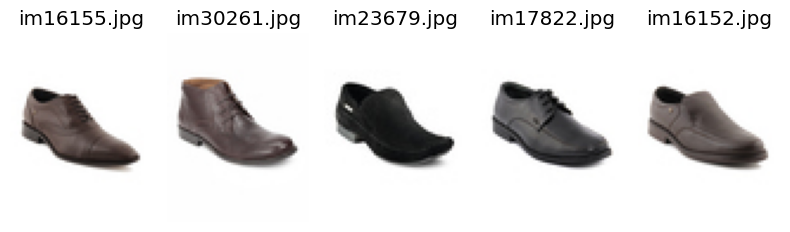

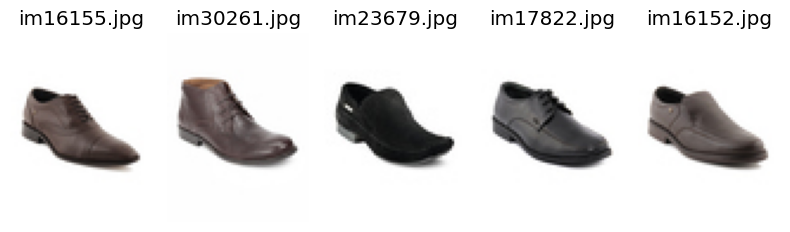

In [ ]:
if __name__ == '__main__':
    app.run()